In [1]:
import logging

import pandas as pd
from scipy.stats import loguniform
import matplotlib.pyplot as plt
import seaborn as sns

import net.net as net
import net.io as io

import training.training as training
import training.utils as utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.set_option('display.max_columns', None)
# Configure root logger to show logs from all imported modules
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)

# Remove any existing handlers to avoid duplicate logs
for handler in root_logger.handlers[:]:
    root_logger.removeHandler(handler)

# Add a stream handler with formatting
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root_logger.addHandler(handler)

# Also configure this module's logger
logger = logging.getLogger(__name__)

In [4]:
train_loader, val_loader = training.create_dataloaders(
    train_path="training/train_data_10000",
    val_path="training/val_data_10000",
    batch_size=2048,
    num_workers=8
)

/mnt/c/Users/janhe/OneDrive/Plocha/repos/glideator/analytics/env-jl/lib/python3.10/site-packages/webdataset/compat.py:136: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn("WebDataset(shardshuffle=...) is None; set explicitly to False or a number")


In [5]:
N_ITER = 20
PATIENCE = 3

SEARCH_SPACE = {
    # 'learning_rate': loguniform(1e-4, 1e-2),
    'l1_lambda': loguniform(1e-6, 1e-3),
    'l2_lambda': loguniform(1e-6, 1e-3),
    'deep_hidden_units': [[64, 32], [128, 64, 32], [256, 128, 64, 32]],
    'parallel_deep_hidden_units': [[64, 32], [128, 64, 32], [256, 128, 64, 32]],
    'site_embedding_dim': [32, 64],
}
FIXED_PARAMS = {
    'weather_scaler': io.load_net('training/models/weather_scaler.pth'),
    'site_scaler': io.load_net('training/models/site_scaler.pth'),
    'num_launches': 251,
    'num_targets': 11,
    'cross_layers': 2,
    'lr_decay': 0.99,
    'num_epochs': 30,
    'prediction_head_type': "ordinal",
    'monotonicity_lambda': 10,
    'learning_rate': 0.001
}

results_df = training.perform_hyperparameter_search(
    net.ExpandedGlideatorNet,
    train_loader,
    val_loader,
    SEARCH_SPACE,
    FIXED_PARAMS,
    N_ITER,
    patience=PATIENCE
)

print("Hyperparameter Search Results:")
results_df.sort_values(by='best_val_loss', ascending=True).head()

2025-05-21 16:49:56,975 - net.io - INFO - Loading neural network model from training/models/weather_scaler.pth
/mnt/c/Users/janhe/OneDrive/Plocha/repos/glideator/analytics/env-jl/lib/python3.10/site-packages/net/io.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the load

Hyperparameter Search Results:


,best_val_loss,best_train_loss,best_epoch,deep_hidden_units,l1_lambda,l2_lambda,parallel_deep_hidden_units,site_embedding_dim,model_info
13,1.445609,5.648751e+06,25,"[128, 64, 32]",0.000212,0.000658,"[128, 64, 32]",64,{'model': ExpandedGlideatorNet( (weather_sca...
3,1.447932,5.611941e+06,13,"[128, 64, 32]",0.000147,0.000654,"[128, 64, 32]",64,{'model': ExpandedGlideatorNet( (weather_sca...
19,1.449077,2.013651e+06,15,"[64, 32]",0.000136,0.000235,"[256, 128, 64, 32]",32,{'model': ExpandedGlideatorNet( (weather_sca...
4,1.452685,5.867070e+05,12,"[64, 32]",0.000071,0.000068,"[64, 32]",64,{'model': ExpandedGlideatorNet( (weather_sca...
16,1.457121,1.009027e+05,22,"[256, 128, 64, 32]",0.000306,0.000012,"[64, 32]",32,{'model': ExpandedGlideatorNet( (weather_sca...


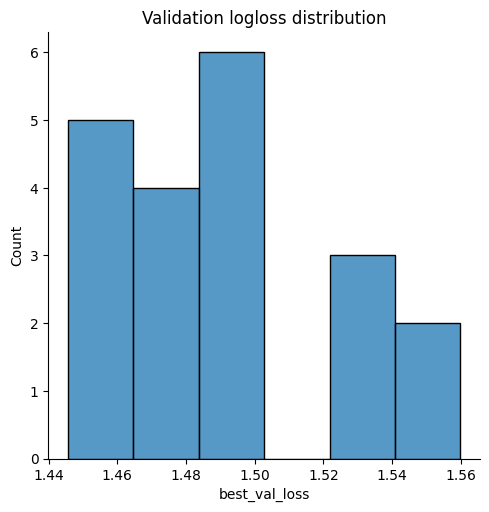

In [6]:
sns.displot(results_df['best_val_loss'])
plt.title('Validation logloss distribution')
plt.show()

2025-05-23 06:19:21,893 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 06:19:21,897 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


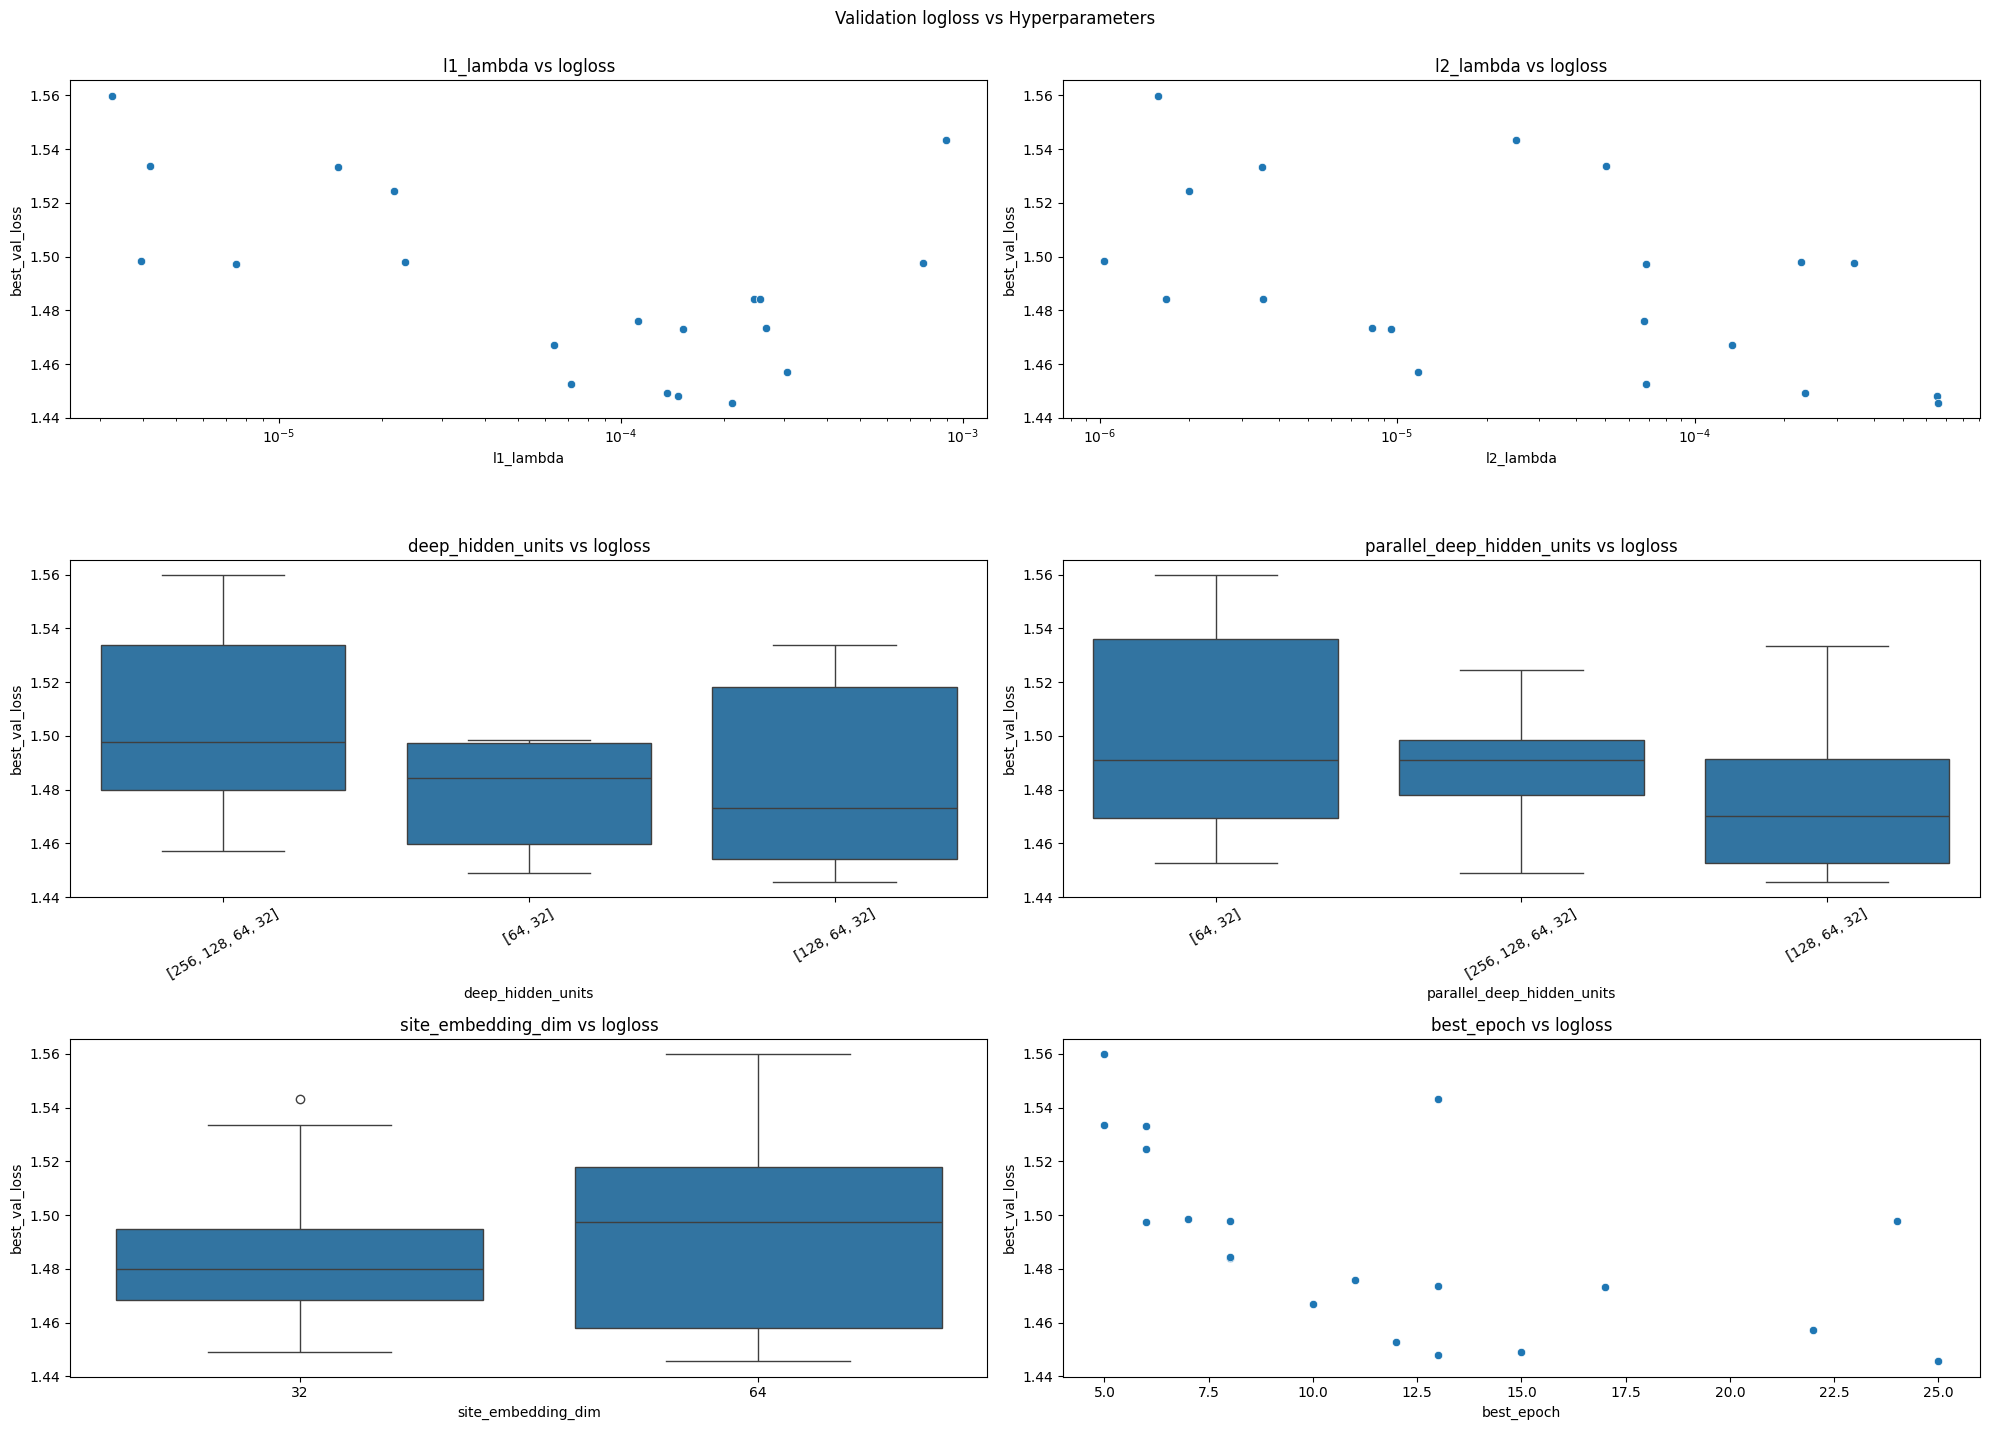

In [7]:
# Identify keys based on their nature in the search space or how they should be plotted
list_keys = ['deep_hidden_units', 'parallel_deep_hidden_units'] # Parameters whose values are lists
discrete_keys = ['site_embedding_dim'] # Parameters with a discrete set of non-list values
continuous_keys = ['learning_rate', 'l1_lambda', 'l2_lambda'] # Parameters sampled from distributions
other_keys_to_plot = ['best_epoch'] # Other numeric results to plot

plot_keys = list(SEARCH_SPACE.keys()) + other_keys_to_plot

n_rows = (len(plot_keys) + 1) // 2

fig, axes = plt.subplots(n_rows, 2, figsize=(20, 5*n_rows))
axes = axes.flatten()

# Keep track of temporary string columns created for list parameters
temp_str_cols = {}

for i, key in enumerate(plot_keys):
    if key not in results_df.columns:
        print(f"Warning: Key '{key}' not found in results_df. Skipping plot.")
        if i < len(axes):
             axes[i].text(0.5, 0.5, f"Key '{key}' not found", ha='center', va='center')
             axes[i].set_title(f'{key} vs logloss (Not Found)')
        continue

    ax = axes[i]
    plot_col_name = key # Default column name to use for plotting

    if key in list_keys:
        # Convert list column to string type for categorical plotting (boxplot)
        # Create the string column only once if needed
        if key not in temp_str_cols:
            str_col_name = f"{key}_str"
            results_df[str_col_name] = results_df[key].astype(str)
            temp_str_cols[key] = str_col_name
        plot_col_name = temp_str_cols[key] # Use the string version for plotting

        sns.boxplot(x=plot_col_name, y='best_val_loss', data=results_df, ax=ax)
        ax.set_xlabel(key) # Label x-axis with the original key name
        ax.tick_params(axis='x', rotation=30) # Rotate labels if they are long

    elif key in discrete_keys:
        # Use boxplot for discrete numerical/categorical parameters
        sns.boxplot(x=key, y='best_val_loss', data=results_df, ax=ax)

    elif key in continuous_keys or key in other_keys_to_plot:
        # Use scatterplot for continuous parameters or other numeric results like best_epoch
        sns.scatterplot(x=key, y='best_val_loss', data=results_df, ax=ax)
        # Set x-axis to logarithmic scale for specific continuous variables if appropriate
        if key in ['learning_rate', 'l1_lambda', 'l2_lambda']:
            ax.set_xscale('log')
    else:
        # Fallback for any unexpected keys - attempt scatterplot with a warning
        print(f"Warning: Plotting key '{key}' with default scatterplot. Type might be incompatible.")
        try:
            sns.scatterplot(x=key, y='best_val_loss', data=results_df, ax=ax)
        except Exception as e:
            print(f"Error plotting key '{key}': {e}")
            ax.text(0.5, 0.5, f"Cannot plot '{key}'", ha='center', va='center')

    ax.set_title(f'{key} vs logloss')

# Remove any unused subplots
for j in range(len(plot_keys), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Validation logloss vs Hyperparameters')
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
plt.show()

# Optional: Clean up temporary string columns from the DataFrame
# for str_col in temp_str_cols.values():
#     if str_col in results_df.columns:
#         del results_df[str_col]

In [8]:
model_info = results_df.loc[0]['model_info']

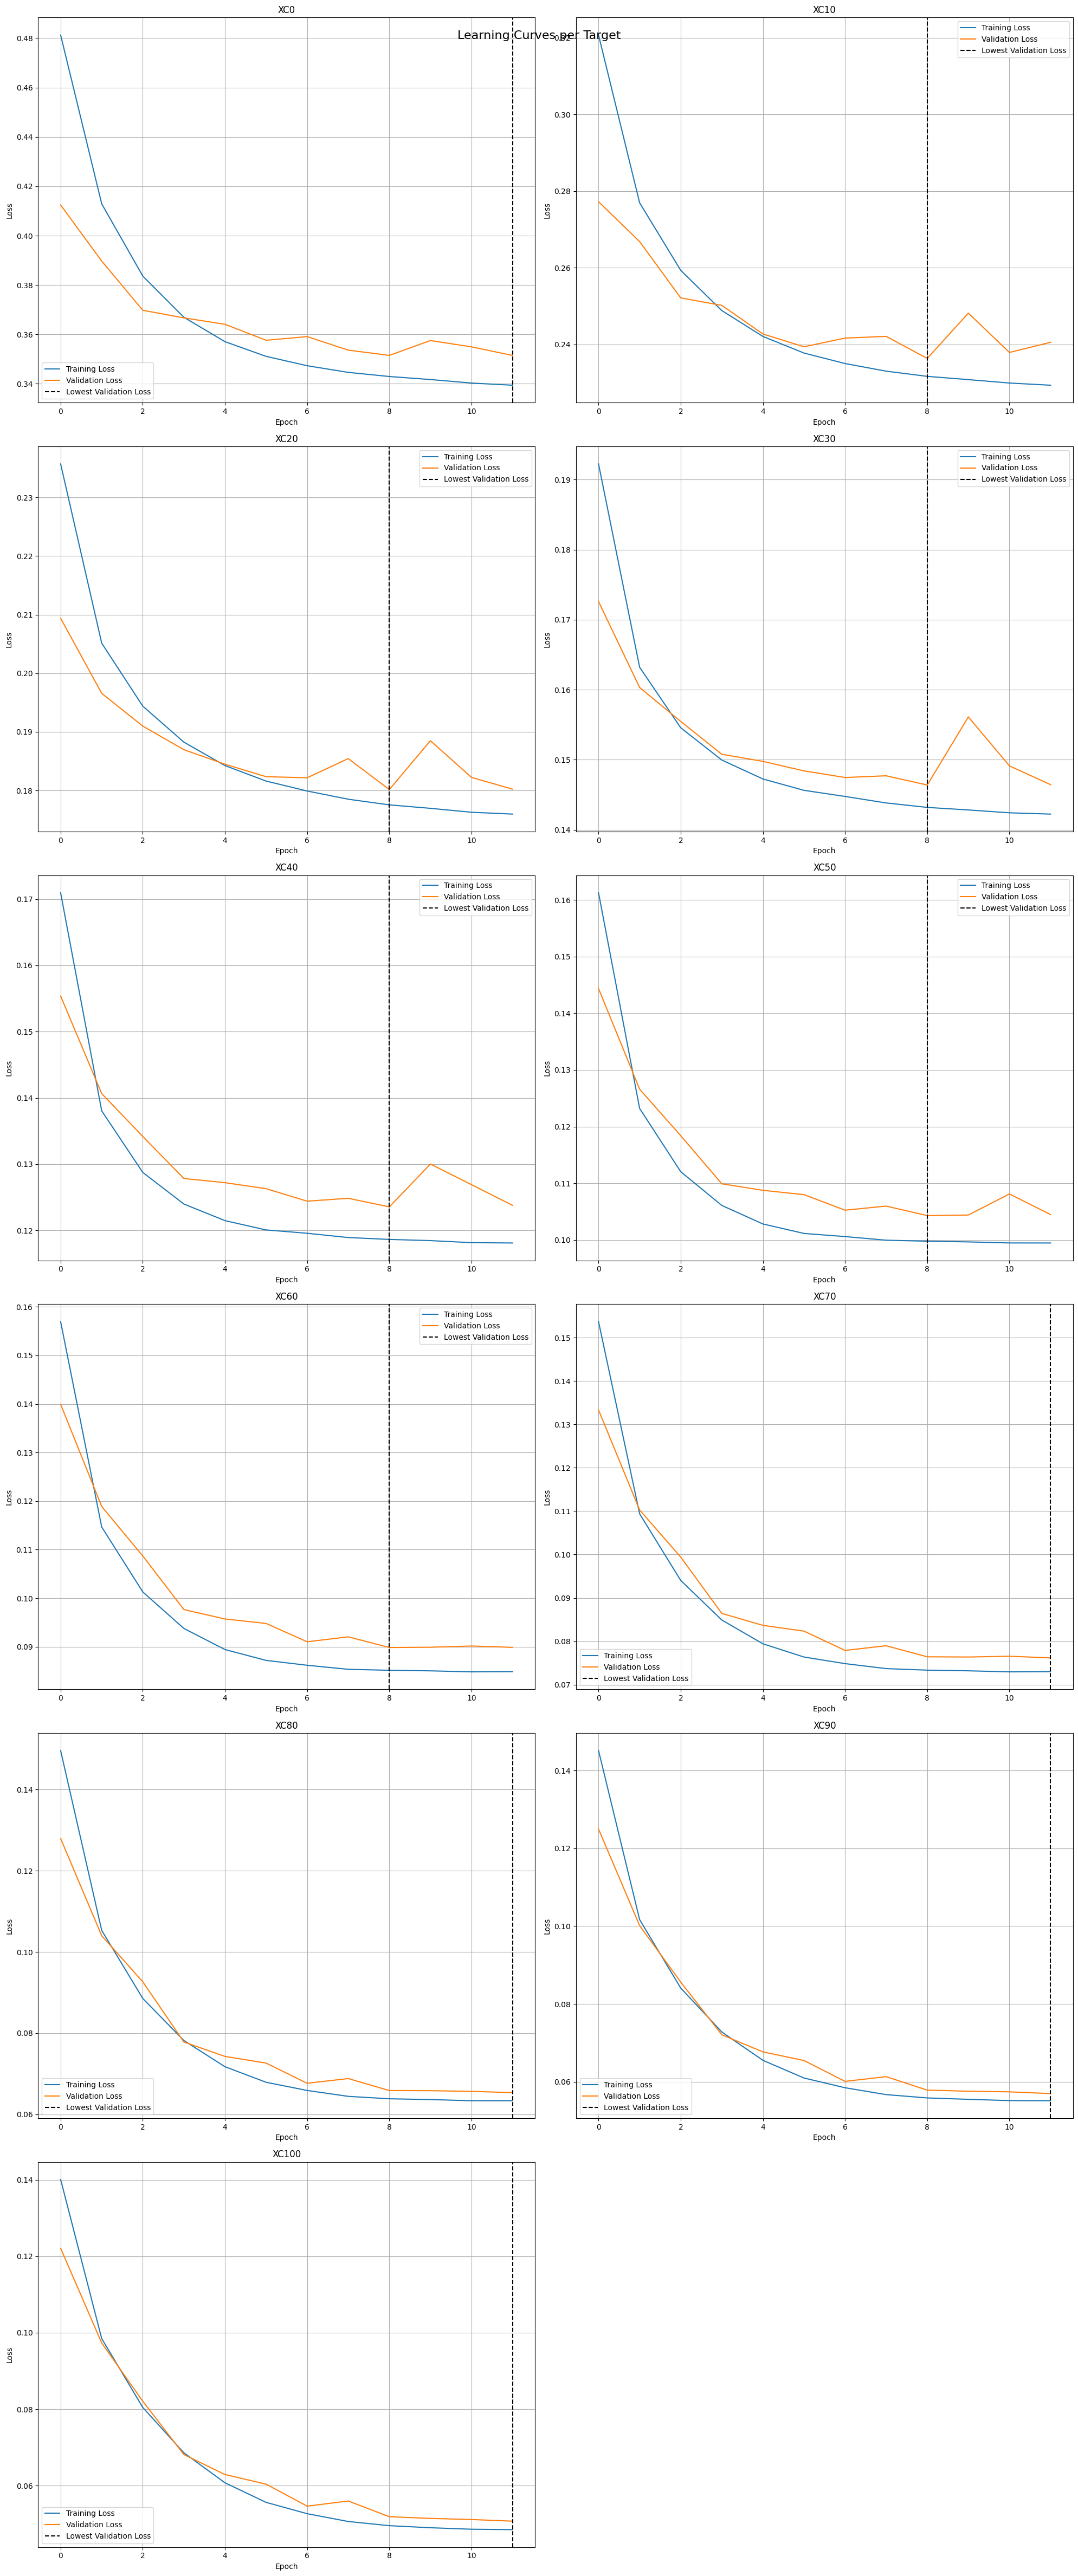

In [9]:
targets = [f'XC{threshold}' for threshold in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]]
utils.plot_learning_curves_per_target(model_info['train_losses_per_target'], model_info['val_losses_per_target'], targets)

In [10]:
import pickle

# Save the results DataFrame to a pickle file
with open('grid_search_results.pkl', 'wb') as f:
    pickle.dump(results_df, f)